# Basic Preprocessing - Tweet Contents

In [1]:
import os
import pandas as pd

In [135]:
contents_raw = pd.read_csv('contents.csv')

In [ ]:
# convert date into other format
for index, row in contents.iterrows():
     contents.loc[index, 'date'] = row['created_at'].split(' ')[1] + ' ' + row['created_at'].split(' ')[2]

In [ ]:
contents = contents.drop(['created_at'], axis = 1)

In [ ]:
#clean tweets, get rid of hashtags and emojis
import re
def clean_tweet(tweet):
    return ' '.join(re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', tweet).split())

In [ ]:
contents['text'] = contents['text'].apply(lambda x: clean_tweet(x))

In [ ]:
#filter out location
contents['place'] = contents['place'].str.upper()
contents = contents[(contents.place != '') & (contents.place != ' ')]

In [ ]:
contents['place'] = contents['place'].str.extract(r"^[^,]+,\s*([^,]+)", expand=False).fillna('no match')

In [ ]:
contents['place'] = contents['place'].apply(lambda x: clean_tweet(x))

In [ ]:
contents['filtered'] = 'Yes'
state_list = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY",'ALABAMA', 'ALASKA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'COLORADO', 'CONNECTICUT', 'DELAWARE', 'FLORIDA', 'GEORGIA', 'HAWAII', 'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MAINE', 'MARYLAND', 'MASSACHUSETTS', 'MICHIGAN', 'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 'MONTANA', 'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA', 'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA', 'RHODE ISLAND', 'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'UTAH', 'VERMONT', 'VIRGINIA', 'WASHINGTON', 'WEST VIRGINIA', 'WISCONSIN', 'WYOMING']

for each in state_list:
    for index, row in contents.iterrows():
    
        if row['place'] == each:
            
            contents.loc[index,'filtered'] = 'No'
            print('###')
            print(row['place'] + " " + each)

In [20]:
contents = contents[contents['filtered'] == 'No']

In [21]:
for index, row in contents.iterrows():
    if row['place'] == 'WASHINGTON':
        contents.loc[index, 'place'] = 'WA'

In [22]:
len(contents['place'].unique())

51

In [ ]:
states = [("AL","Alabama"),("AK","Alaska"),("AZ","Arizona"),("AR","Arkansas"),("CA", "California"),("CO", "Colorado"),
("CT","Connecticut"),("DC","Washington DC"),("DE","Delaware"),("FL","Florida"),("GA","Georgia"),
("HI","Hawaii"),("ID","Idaho"),("IL","Illinois"),("IN","Indiana"),("IA","Iowa"),("KS","Kansas"),("KY","Kentucky"),
("LA","Louisiana"),("ME","Maine"),("MD","Maryland"),("MA","Massachusetts"),("MI","Michigan"),("MN","Minnesota"),
("MS","Mississippi"),("MO","Missouri"),("MT","Montana"),("NE","Nebraska"),("NV","Nevada"),("NH","New Hampshire"),
("NJ","New Jersey"),("NM","New Mexico"),("NY","New York"),("NC","North Carolina"),("ND","North Dakota"),("OH","Ohio"),
("OK","Oklahoma"),("OR","Oregon"),("PA","Pennsylvania"),("RI","Rhode Island"),("SC","South Carolina"),("SD","South Dakota"),
("TN","Tennessee"),("TX","Texas"),("UT","Utah"),("VT","Vermont"),("VA","Virginia"),("WA","Washington"),("WV","West Virginia"),
("WI","Wisconsin"),("WY","Wyoming")]

for each in states:
    for i, row in contents.iterrows():
        if each[0] == row['place']:
            print('here')
            contents.loc[i, 'place'] = each[1]

In [24]:
contents = contents.drop(['user_location','filtered'], axis = 1)

In [4]:
# adjust the format of dates
contents['date'] = contents['date'].apply(str) 

for i, row in contents.iterrows():
        contents.loc[i, 'date'] = row['date'] + ' 2020'

In [5]:
from datetime import datetime

for index, row in contents.iterrows():
    d = datetime.strptime(row['date'],'%b %d %Y')
    contents.loc[index,'date'] = d.strftime('%m-%d-%Y')

In [ ]:
list(contents['date'].unique())

In [7]:
contents['user_location'] = contents.user_location.fillna(contents.place)

In [8]:
contents = contents.drop(['place'],axis = 1)

In [9]:
contents = contents.sort_values(by = 'date')

# Standardization and Sentiment Analysis for Each Tweet

In [11]:
from textblob import TextBlob
contents['polarity'] = 0
contents['subjectivity'] = 0

In [12]:
import matplotlib.pyplot as plt

In [13]:
for index, row in contents.iterrows():
    
    ts = TextBlob(row['text']).sentiment
    contents.loc[index, 'polarity'] = ts.polarity
    contents.loc[index, 'subjectivity'] = ts.subjectivity

In [18]:
#instead of maxmin normalization, standardization might be a better fit. Maxmin normalization will make data have (0,1) value
#range and here, we actually have (-1,1) range which has specific meanings in it.
# Standardization will recscale data into a Gaussian distribution with 0 mean and 1 as standard deviztion.

from sklearn.preprocessing import StandardScaler
polarity = contents.polarity
polarity = polarity.values.reshape((len(contents.polarity), 1))

scaler = StandardScaler() 
polarity_standard = scaler.fit_transform(polarity)

In [16]:
contents['polarity_standard'] = polarity_standard

# How many negative posts every day?

In [19]:
contents_negative = contents[contents['polarity'] < 0]

In [20]:
contents_negative_grouped = contents_negative.groupby(['date'], as_index = False).agg({'id':'count'})

In [21]:
contents_negative_grouped = contents_negative_grouped.sort_values(by = 'date')

([<matplotlib.axis.XTick at 0x282bf93ec88>,
 <a list of 9 Text xticklabel objects>)

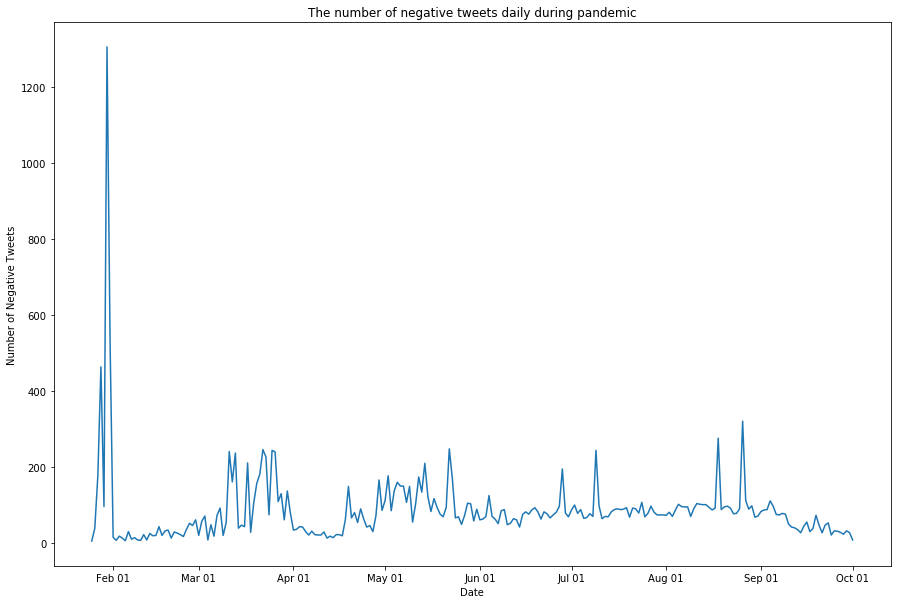

In [23]:
plt.figure(figsize=(15, 10))

plt.plot(contents_negative_grouped['date'],contents_negative_grouped['id'])
plt.ylabel('Number of Negative Tweets')
plt.xlabel('Date')
plt.title('The number of negative tweets daily during pandemic')
positions = ('02-01-2020','03-01-2020','04-01-2020','05-01-2020','06-01-2020','07-01-2020','08-01-2020', '09-01-2020','10-01-2020')
labels = ('Feb 01','Mar 01','Apr 01','May 01','Jun 01','Jul 01','Aug 01','Sep 01', 'Oct 01')
plt.xticks(positions, labels)

# How many positive posts every day?

In [24]:
contents_positive = contents[contents['polarity'] >= 0]
contents_positive_grouped = contents_positive.groupby(['date'], as_index = False).agg({'id':'count'})
contents_positive_grouped = contents_positive_grouped.sort_values(by = 'date')

([<matplotlib.axis.XTick at 0x282bfab94c8>,
 <a list of 9 Text xticklabel objects>)

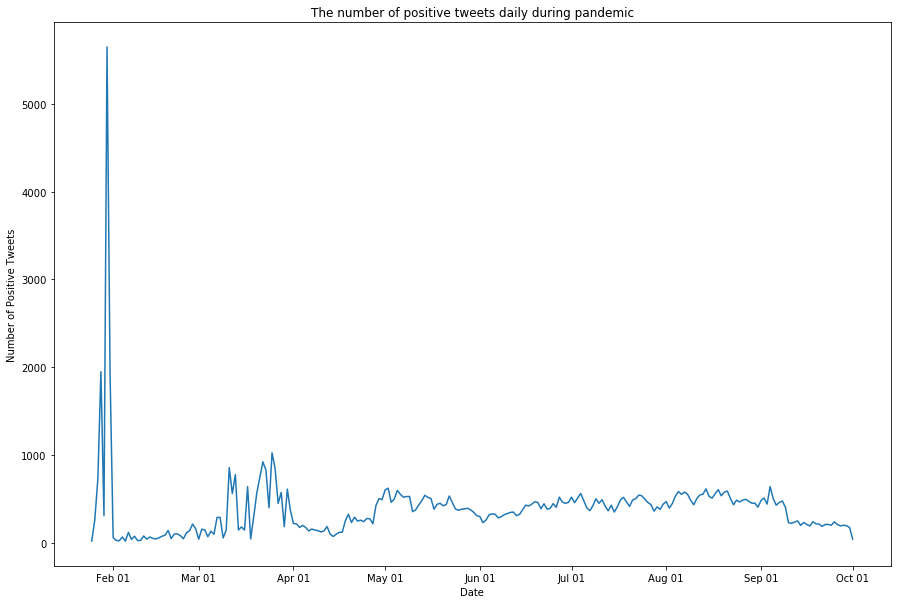

In [25]:
plt.figure(figsize=(15, 10))

plt.plot(contents_positive_grouped['date'],contents_positive_grouped['id'])
plt.ylabel('Number of Positive Tweets')
plt.xlabel('Date')
plt.title('The number of positive tweets daily during pandemic')
positions = ('02-01-2020','03-01-2020','04-01-2020','05-01-2020','06-01-2020','07-01-2020','08-01-2020', '09-01-2020','10-01-2020')
labels = ('Feb 01','Mar 01','Apr 01','May 01','Jun 01','Jul 01','Aug 01','Sep 01', 'Oct 01')
plt.xticks(positions, labels)

# Total number of tweets every day

In [26]:
contents = contents.sort_values(by = 'date')
contents_grouped = contents.groupby(['date'], as_index = False).agg({'id':'count'})

([<matplotlib.axis.XTick at 0x282bf986888>,
 <a list of 9 Text xticklabel objects>)

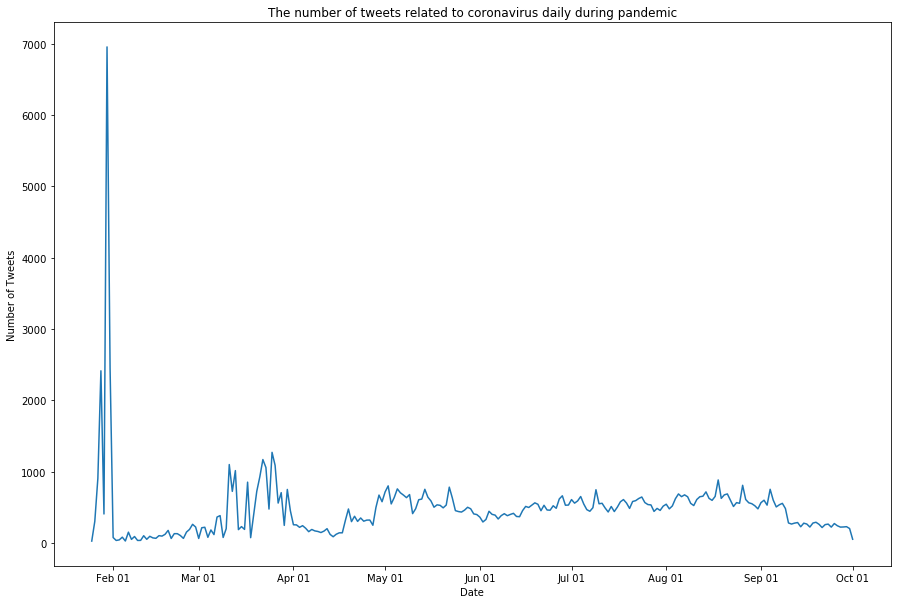

In [27]:
plt.figure(figsize=(15, 10))

plt.plot(contents_grouped['date'],contents_grouped['id'])
plt.ylabel('Number of Tweets')
plt.xlabel('Date')
plt.title('The number of tweets related to coronavirus daily during pandemic')
positions = ('02-01-2020','03-01-2020','04-01-2020','05-01-2020','06-01-2020','07-01-2020','08-01-2020', '09-01-2020','10-01-2020')
labels = ('Feb 01','Mar 01','Apr 01','May 01','Jun 01','Jul 01','Aug 01','Sep 01', 'Oct 01')
plt.xticks(positions, labels)

# How about sentiment score every day?

In [29]:
contents_grouped_text = contents.groupby(['date'], as_index = False).agg({'text': ' '.join})

In [30]:
contents_grouped_text['polarity'] = 0
contents_grouped_text['subjectivity'] = 0

In [31]:
for index, row in contents_grouped_text.iterrows():
    
    ts = TextBlob(row['text']).sentiment
    contents_grouped_text.loc[index, 'polarity'] = ts.polarity
    contents_grouped_text.loc[index, 'subjectivity'] = ts.subjectivity

In [32]:
polarity_grouped = contents_grouped_text.polarity
polarity_grouped = polarity_grouped.values.reshape((len(contents_grouped_text.polarity), 1))

scaler = StandardScaler() 
polarity_grouped_standard = scaler.fit_transform(polarity_grouped)

In [33]:
contents_grouped_text['polarity_grouped_standard'] = polarity_grouped_standard

([<matplotlib.axis.XTick at 0x282c51a0948>,
 <a list of 9 Text xticklabel objects>)

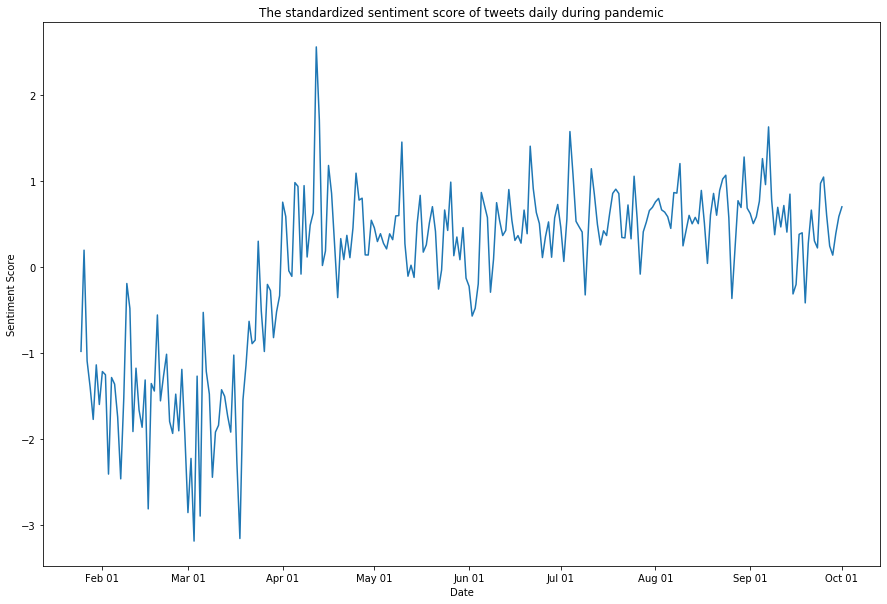

In [34]:
plt.figure(figsize=(15, 10))

plt.plot(contents_grouped_text['date'],contents_grouped_text['polarity_grouped_standard'])
plt.ylabel('Sentiment Score')
plt.xlabel('Date')
plt.title('The standardized sentiment score of tweets daily during pandemic')
positions = ('02-01-2020','03-01-2020','04-01-2020','05-01-2020','06-01-2020','07-01-2020','08-01-2020', '09-01-2020','10-01-2020')
labels = ('Feb 01','Mar 01','Apr 01','May 01','Jun 01','Jul 01','Aug 01','Sep 01', 'Oct 01')
plt.xticks(positions, labels)

# How is the trend after grouping by region and date?

In [38]:
northeast = ['Maine', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New Hampshire', 'Vermont', 'New York', 'Pennsylvania', 'New Jersey', 'Delaware', 'Maryland']
southeast = ['West Virginia', 'Virginia', 'Kentucky', 'Tennessee', 'North Carolina', 'South Carolina', 'Georgia', 'Alabama', 'Mississippi', 'Arkansas', 'Louisiana', 'Florida']
midwest = ['Ohio', 'Indiana', 'Michigan', 'Illinois', 'Missouri', 'Wisconsin', 'Minnesota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota', 'North Dakota']
southwest = ['Texas', 'Oklahoma', 'New Mexico', 'Arizona']
west = ['Colorado', 'Wyoming', 'Montana', 'Idaho', 'Washington', 'Oregon', 'Utah', 'Nevada', 'California', 'Alaska', 'Hawaii']

for index, row in contents.iterrows():
    if row['user_location'] in northeast:
        contents.loc[index,'region'] = 'northeast'
    elif row['user_location'] in southeast:
        contents.loc[index, 'region'] = 'southeast'
    elif row['user_location'] in midwest:
        contents.loc[index,'region'] = 'midwest'
    elif row['user_location'] in southwest:
        contents.loc[index,'region'] = 'southwest'
    else:
        contents.loc[index,'region'] = 'west'
    

In [39]:
contents.region.unique()

array(['southeast', 'southwest', 'west', 'midwest', 'northeast'],
      dtype=object)

In [47]:
contents_region_date = contents.groupby(['date','region'] ,as_index = False).agg({'text': ' '.join})

In [48]:
contents_region_date['polarity'] = 0
contents_region_date['subjectivity'] = 0

for index, row in contents_region_date.iterrows():
    
    ts = TextBlob(row['text']).sentiment
    contents_region_date.loc[index, 'polarity'] = ts.polarity
    contents_region_date.loc[index, 'subjectivity'] = ts.subjectivity


In [49]:
polarity_region_date = contents_region_date.polarity
polarity_region_date = polarity_region_date.values.reshape((len(contents_region_date.polarity), 1))

scaler = StandardScaler() 
polarity_standard = scaler.fit_transform(polarity_region_date)

In [50]:
contents_region_date['polarity_standard'] = polarity_standard

In [51]:
import seaborn as sns

c:\users\msyim\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\msyim\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


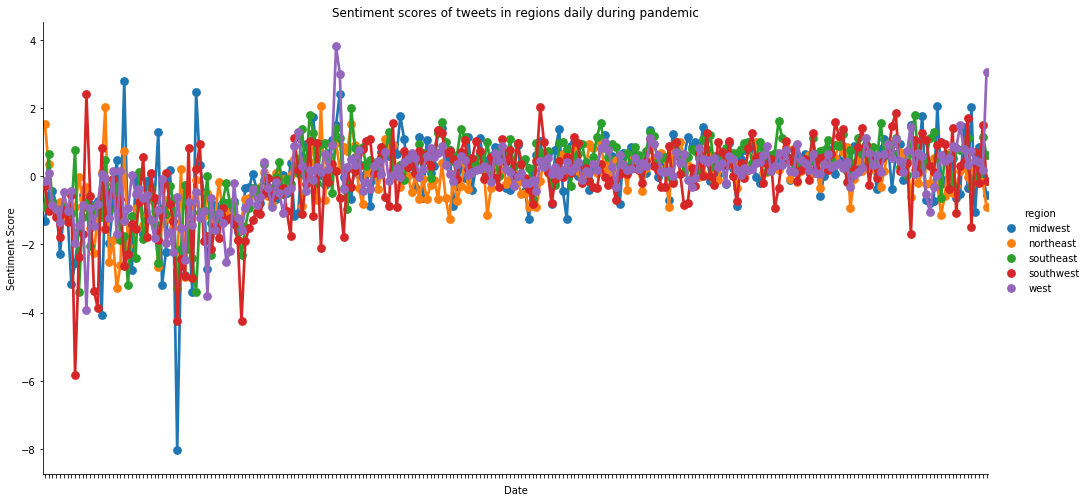

In [46]:
plt_a = sns.factorplot('date','polarity_standard',data = contents_region_date, hue = 'region', size = 7, aspect = 2)
plt_a.set(ylabel = 'Sentiment Score', xlabel = "Date", title = 'Sentiment scores of tweets in regions daily during pandemic')
plt_a.set(xticklabels=[])

# Explore Time-series Pattern in This Dataset and Remove Seasonal Pattern

## Total (Not Separated by Region) 

In [39]:
#decompose the series into trend, seasonal, bease level, and residual
from statsmodels.tsa.seasonal import seasonal_decompose

In [40]:
contents_grouped_text['polarity_grouped_standard'] = contents_grouped_text['polarity_grouped_standard'].fillna(0)

In [41]:
contents_grouped_text = contents_grouped_text.reset_index()

In [42]:
contents_grouped_text['date'] = pd.to_datetime(contents_grouped_text['date'])

In [43]:
contents_grouped_text = contents_grouped_text.set_index('date').asfreq('D')

In [46]:
# Additive Decomposition
result_add = seasonal_decompose(contents_grouped_text['polarity_grouped_standard'], model='additive', extrapolate_trend='freq')

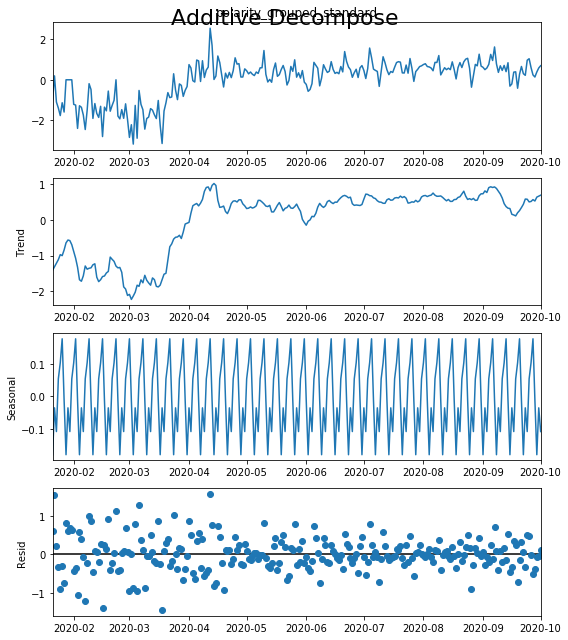

In [47]:
plt.rcParams.update({'figure.figsize': (8,9)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [49]:
# Extract the Components ----
# Actual Values = Seasonal + Trend + Resid
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
2020-01-21,-0.180371,-1.409422,0.609868,-0.979925
2020-01-22,-0.035442,-1.310530,1.539779,0.193807
2020-01-23,-0.108773,-1.211637,0.220152,-1.100258
2020-01-24,0.054209,-1.111932,-0.339447,-1.397170
2020-01-25,0.104075,-0.971943,-0.901531,-1.769398


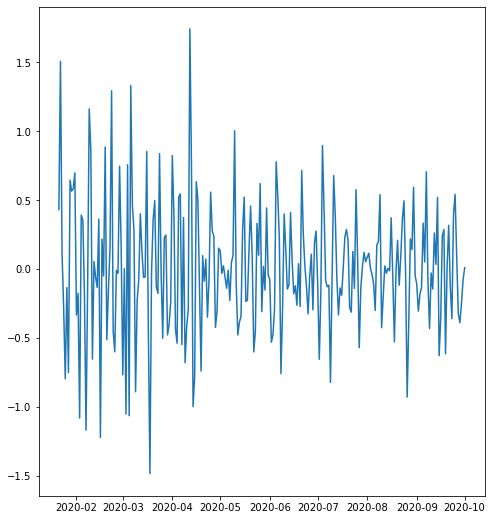

In [50]:
# detrend
detrended = contents_grouped_text['polarity_grouped_standard'] - result_add.trend
plt.plot(detrended)

[]

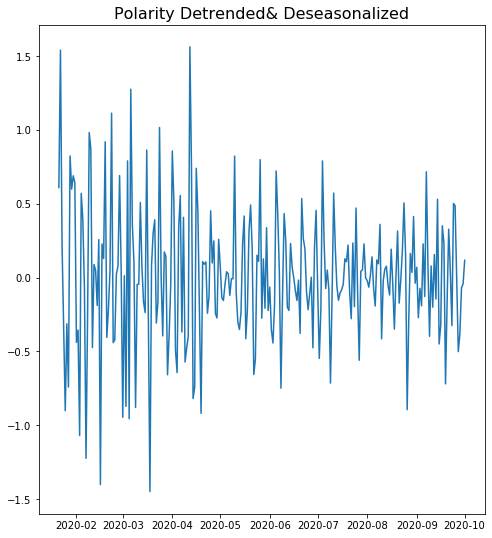

In [51]:
# Deseasonalize
polarity_pure = detrended - result_add.seasonal

# Plot
plt.plot(polarity_pure)
plt.title('Polarity Detrended& Deseasonalized', fontsize=16)
plt.plot()

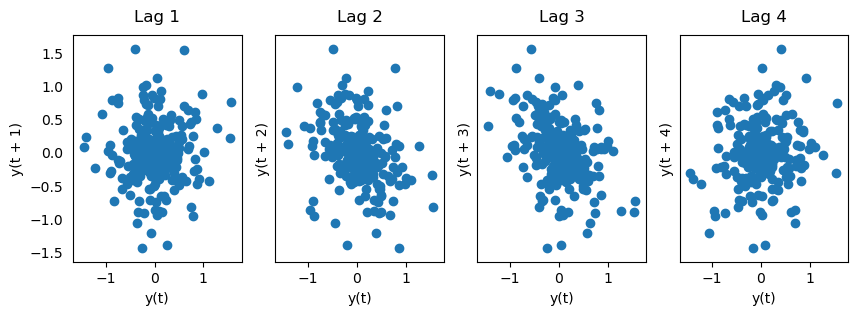

In [53]:
# is there any auto-correlation?
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(polarity_pure, lag=i+1, ax=ax)
    ax.set_title('Lag ' + str(i+1))


# Time-series Analysis Separated by Region

In [61]:
contents_northeast = contents_region_date[contents_region_date.region == 'northeast']
contents_midwest = contents_region_date[contents_region_date.region == 'midwest']
contents_southeast = contents_region_date[contents_region_date.region == 'southeast']
contents_west = contents_region_date[contents_region_date.region == 'west']
contents_southwest = contents_region_date[contents_region_date.region == 'southwest']

### northeast

In [69]:
contents_northeast['polarity_standard'] = contents_northeast['polarity_standard'].fillna(0)
contents_northeast['date'] = pd.to_datetime(contents_northeast['date'] )
contents_northeast = contents_northeast.set_index('date').asfreq('D')

In [70]:
# Additive Decomposition
result_add = seasonal_decompose(contents_northeast['polarity_standard'], model='additive', extrapolate_trend='freq')

In [72]:
# Extract the Components ----
# Actual Values = Seasonal + Trend + Resid
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
2020-01-21,-0.138590,-0.678286,2.355852,1.538977
2020-01-22,-0.007892,-0.657771,1.019789,0.354125
2020-01-23,-0.133302,-0.637256,-0.086601,-0.857160
2020-01-24,-0.093475,-0.454776,-0.459157,-1.007408
2020-01-25,0.089299,-0.674629,-0.206339,-0.791670


In [73]:
detrended = contents_northeast['polarity_standard'] - result_add.trend
polarity_northeast_pure = detrended - result_add.seasonal

In [93]:
polarity_northeast_pure = pd.DataFrame(polarity_northeast_pure)
polarity_northeast_pure = polarity_northeast_pure.reset_index()

In [97]:
polarity_northeast_pure.columns = ['date','sentiment_score_standard']

In [98]:
polarity_northeast_pure

,date,sentiment_score_standard
0,2020-01-21,2.355852
1,2020-01-22,1.019789
2,2020-01-23,-0.086601
3,2020-01-24,-0.459157
4,2020-01-25,-0.206339
...,...,...
250,2020-09-27,-0.326768
251,2020-09-28,0.084771
252,2020-09-29,0.093825
253,2020-09-30,-0.422162


## midwest

In [80]:
contents_midwest['polarity_standard'] = contents_midwest['polarity_standard'].fillna(0)
contents_midwest['date'] = pd.to_datetime(contents_midwest['date'] )
contents_midwest = contents_midwest.set_index('date').asfreq('D')

In [84]:
result_add = seasonal_decompose(contents_midwest['polarity_standard'], model='additive', extrapolate_trend='freq')

In [85]:
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
2020-01-21,-0.028660,-1.005334,-0.276885,-1.310879
2020-01-22,-0.087864,-0.978720,0.525495,-0.541089
2020-01-23,-0.213768,-0.952106,0.745654,-0.420221
2020-01-24,0.308782,-1.079132,-0.028657,-0.799007
2020-01-25,0.263627,-0.891864,-1.638792,-2.267029


In [86]:
detrended = contents_midwest['polarity_standard'] - result_add.trend
polarity_midwest_pure = detrended - result_add.seasonal

In [99]:
polarity_midwest_pure = pd.DataFrame(polarity_midwest_pure)
polarity_midwest_pure = polarity_midwest_pure.reset_index()

In [100]:
polarity_midwest_pure.columns = ['date','sentiment_score_standard']

In [101]:
polarity_midwest_pure

,date,sentiment_score_standard
0,2020-01-21,-0.276885
1,2020-01-22,0.525495
2,2020-01-23,0.745654
3,2020-01-24,-0.028657
4,2020-01-25,-1.638792
...,...,...
250,2020-09-27,1.849357
251,2020-09-28,-1.311575
252,2020-09-29,0.459408
253,2020-09-30,-0.380160


## southeast

In [103]:
contents_southeast['polarity_standard'] = contents_southeast['polarity_standard'].fillna(0)
contents_southeast['date'] = pd.to_datetime(contents_southeast['date'] )
contents_southeast = contents_southeast.set_index('date').asfreq('D')

In [104]:
result_add = seasonal_decompose(contents_southeast['polarity_standard'], model='additive', extrapolate_trend='freq')

In [105]:
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
2020-01-21,-0.224920,-0.941033,0.253894,-0.912059
2020-01-22,0.018163,-0.865992,1.490496,0.642668
2020-01-23,-0.025219,-0.790950,0.076581,-0.739588
2020-01-24,0.041227,-0.690555,-0.363183,-1.012511
2020-01-25,0.103382,-0.560260,-0.539744,-0.996622


In [106]:
detrended = contents_southeast['polarity_standard'] - result_add.trend
polarity_southeast_pure = detrended - result_add.seasonal

In [107]:
polarity_southeast_pure = pd.DataFrame(polarity_southeast_pure)
polarity_southeast_pure = polarity_southeast_pure.reset_index()

In [108]:
polarity_southeast_pure.columns = ['date','sentiment_score_standard']

In [109]:
polarity_southeast_pure

,date,sentiment_score_standard
0,2020-01-21,0.253894
1,2020-01-22,1.490496
2,2020-01-23,0.076581
3,2020-01-24,-0.363183
4,2020-01-25,-0.539744
...,...,...
250,2020-09-27,-0.938645
251,2020-09-28,-0.509088
252,2020-09-29,-0.238580
253,2020-09-30,0.578252


## west

In [111]:
contents_west['polarity_standard'] = contents_west['polarity_standard'].fillna(0)
contents_west['date'] = pd.to_datetime(contents_west['date'] )
contents_west = contents_west.set_index('date').asfreq('D')

In [112]:
result_add = seasonal_decompose(contents_west['polarity_standard'], model='additive', extrapolate_trend='freq')

In [113]:
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
2020-01-21,-0.066205,-0.855235,0.772992,-0.148448
2020-01-22,-0.110875,-0.800156,0.994027,0.082996
2020-01-23,0.019072,-0.745077,-0.109612,-0.835617
2020-01-24,0.056558,-0.667540,-0.347585,-0.958567
2020-01-25,-0.046920,-0.646333,-0.642124,-1.335377


In [114]:
detrended = contents_west['polarity_standard'] - result_add.trend
polarity_west_pure = detrended - result_add.seasonal

In [115]:
polarity_west_pure = pd.DataFrame(polarity_west_pure)
polarity_west_pure = polarity_west_pure.reset_index()

In [116]:
polarity_west_pure.columns = ['date','sentiment_score_standard']

In [117]:
polarity_west_pure

,date,sentiment_score_standard
0,2020-01-21,0.772992
1,2020-01-22,0.994027
2,2020-01-23,-0.109612
3,2020-01-24,-0.347585
4,2020-01-25,-0.642124
...,...,...
250,2020-09-27,-0.056093
251,2020-09-28,-0.364248
252,2020-09-29,-0.202244
253,2020-09-30,-0.399638


## southwest

In [120]:
contents_southwest['polarity_standard'] = contents_southwest['polarity_standard'].fillna(0)
contents_southwest['date'] = pd.to_datetime(contents_southwest['date'] )
contents_southwest = contents_southwest.set_index('date').asfreq('D')

In [121]:
result_add = seasonal_decompose(contents_southwest['polarity_standard'], model='additive', extrapolate_trend='freq')

In [122]:
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
2020-01-21,-0.151603,-1.153169,1.015093,-0.289679
2020-01-22,0.073026,-1.100929,0.010385,-1.017518
2020-01-23,-0.023440,-1.048689,0.168815,-0.903314
2020-01-24,0.049823,-1.077863,-0.173921,-1.201961
2020-01-25,0.236735,-1.036480,-0.983208,-1.782954


In [123]:
detrended = contents_southwest['polarity_standard'] - result_add.trend
polarity_southwest_pure = detrended - result_add.seasonal

In [124]:
polarity_southwest_pure = pd.DataFrame(polarity_southwest_pure)
polarity_southwest_pure = polarity_southwest_pure.reset_index()

In [125]:
polarity_southwest_pure.columns = ['date','sentiment_score_standard']

In [126]:
polarity_southwest_pure

,date,sentiment_score_standard
0,2020-01-21,1.015093
1,2020-01-22,0.010385
2,2020-01-23,0.168815
3,2020-01-24,-0.173921
4,2020-01-25,-0.983208
...,...,...
250,2020-09-27,-1.878793
251,2020-09-28,0.497153
252,2020-09-29,-0.196479
253,2020-09-30,1.310855


# Basic Preprocessing - COVID Data

In [53]:
confirmed = pd.read_csv('time_series_covid19_confirmed_US.csv')
death = pd.read_csv('time_series_covid19_deaths_US.csv')

In [54]:
confirmed = confirmed.drop(['UID','iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key'], axis = 1)

In [55]:
confirmed_region = confirmed.melt(id_vars = ['Province_State'], var_name = 'date',value_name = 'cases')

In [56]:
confirmed_all = pd.DataFrame(confirmed.sum(axis = 0), columns = ['confirmed']).reset_index().drop([0],axis = 0)

In [57]:
confirmed_all['index'] = pd.to_datetime(confirmed_all['index'])

In [58]:
confirmed_all = confirmed_all[(pd.to_datetime('2020-01-21')<= confirmed_all['index']) & (confirmed_all['index'] <= pd.to_datetime('2020-10-01'))]

In [60]:
death = death.drop(['UID','iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key','Population'], axis = 1)

In [62]:
death_region = death.melt(id_vars = ['Province_State'], var_name = 'date',value_name = 'cases')

In [63]:
death_all = pd.DataFrame(death.sum(axis = 0), columns = ['confirmed']).reset_index().drop([0],axis = 0)

In [65]:
death_all['index'] = pd.to_datetime(death_all['index'])

In [66]:
death_all = death_all[(pd.to_datetime('2020-01-21')<= death_all['index']) & (death_all['index'] <= pd.to_datetime('2020-10-01'))]

In [68]:
death_all = death_all.set_index('index')
confirmed_all = confirmed_all.set_index('index')

In [69]:
confirmed_death = pd.concat([death_all, confirmed_all], axis = 1,names = ['death','confirmed']).reset_index()

In [70]:
confirmed_death.columns = ['date','death','confirmed']

In [71]:
confirmed_death = confirmed_death.reset_index()

Text(0.5, 0, 'Date')

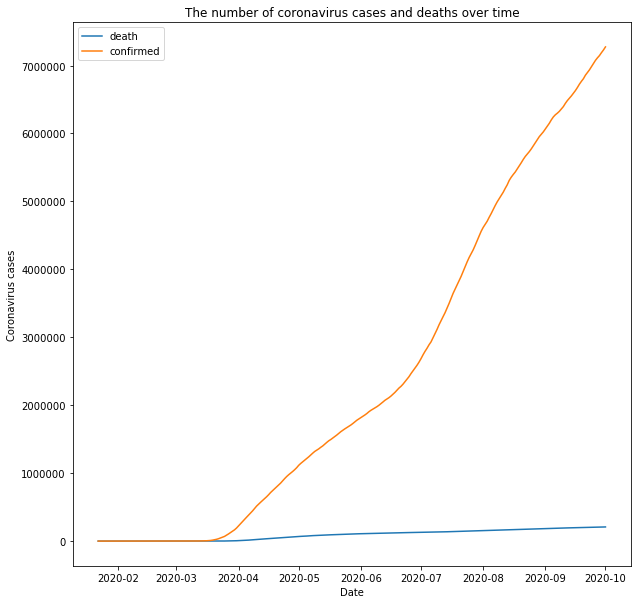

In [72]:


plt.figure(figsize=(10, 10))

plt.plot(confirmed_death['date'],confirmed_death['death'], label = 'death')
plt.plot(confirmed_death['date'],confirmed_death['confirmed'], label = 'confirmed')
plt.legend(loc="upper left")
plt.title('The number of coronavirus cases and deaths over time')
plt.ylabel('Coronavirus cases')
plt.xlabel('Date')
#positions = ('2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01', '2020-09-01','2020-10-01')
#labels = ('Apr 01','May 01','Jun 01','Jul 01','Aug 01','Sep 01', 'Oct 01')
#plt.xticks(positions, labels)


In [73]:
confirmed_region = confirmed_region.set_index(['date','Province_State'])

In [74]:
death_region = death_region.set_index(['date','Province_State'])

In [75]:
death_confirmed_region = pd.concat([death_region, confirmed_region], axis = 1,names = ['date','state','death','confirmed']).reset_index()

In [76]:
death_confirmed_region['date'] = pd.to_datetime(death_confirmed_region['date'])

In [77]:
death_confirmed_region = death_confirmed_region[(pd.to_datetime('2020-01-21')<= death_confirmed_region['date']) & (death_confirmed_region['date'] <= pd.to_datetime('2020-10-01'))]

In [78]:
death_confirmed_region.columns = ['date','state','death','confirmed']

In [79]:
death_confirmed_region

,date,state,death,confirmed
0,2020-01-22,Alabama,0,0
1,2020-01-22,Alabama,0,0
2,2020-01-22,Alabama,0,0
3,2020-01-22,Alabama,0,0
4,2020-01-22,Alabama,0,0
...,...,...,...,...
848355,2020-10-01,Wyoming,1,591
848356,2020-10-01,Wyoming,2,356
848357,2020-10-01,Wyoming,0,0
848358,2020-10-01,Wyoming,6,116


In [80]:
for index, row in death_confirmed_region.iterrows():
    if row['state'] in northeast:
        death_confirmed_region.loc[index,'region'] = 'northeast'
    elif row['state'] in southeast:
        death_confirmed_region.loc[index, 'region'] = 'southeast'
    elif row['state'] in midwest:
        death_confirmed_region.loc[index,'region'] = 'midwest'
    elif row['state'] in southwest:
        death_confirmed_region.loc[index,'region'] = 'southwest'
    else:
        death_confirmed_region.loc[index,'region'] = 'west'

c:\users\msyim\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\msyim\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


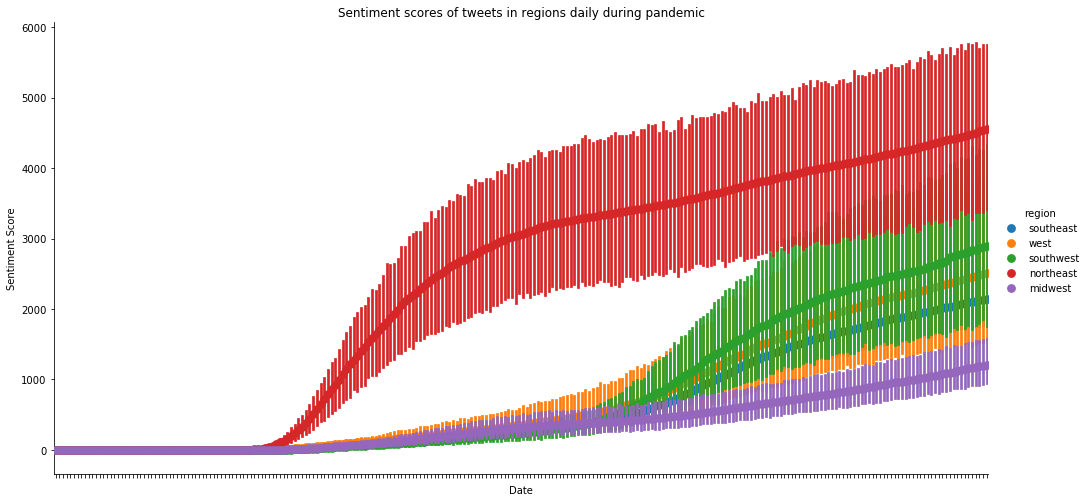

In [84]:
plt_b = sns.factorplot('date','confirmed',data = death_confirmed_region, hue = 'region', size = 7, aspect = 2)

plt_b.set(ylabel = 'Sentiment Score', xlabel = "Date", title = 'Sentiment scores of tweets in regions daily during pandemic')
plt_b.set(xticklabels=[])

In [85]:
confirmed = confirmed_death.confirmed
confirmed = confirmed.values.reshape((len(confirmed_death.confirmed), 1))

scaler = StandardScaler() 
confirmed_standard = scaler.fit_transform(confirmed)

In [86]:
confirmed_death['confirmed_standard'] = confirmed_standard

# standardize by regions

In [88]:
death_confirmed_region = death_confirmed_region.groupby(['date','region']).agg({'confirmed':'sum'}).reset_index()

In [89]:
covid_northeast = death_confirmed_region[death_confirmed_region.region == 'northeast']
covid_midwest = death_confirmed_region[death_confirmed_region.region == 'midwest']
covid_southeast = death_confirmed_region[death_confirmed_region.region == 'southeast']
covid_west = death_confirmed_region[death_confirmed_region.region == 'west']
covid_southwest = death_confirmed_region[death_confirmed_region.region == 'southwest']

### northeast

In [174]:
confirmed = covid_northeast.confirmed
confirmed = confirmed.values.reshape((len(covid_northeast.confirmed), 1))

scaler = StandardScaler() 
confirmed_standard = scaler.fit_transform(confirmed)

covid_northeast['confirmed_standard'] = confirmed_standard

c:\users\msyim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [175]:
covid_northeast = covid_northeast.set_index('date')

In [176]:
covid_northeast

,region,confirmed,confirmed_standard
date,,,
2020-01-22,northeast,0,-1.428242
2020-01-23,northeast,0,-1.428242
2020-01-24,northeast,0,-1.428242
2020-01-25,northeast,0,-1.428242
2020-01-26,northeast,0,-1.428242
...,...,...,...
2020-09-27,northeast,1198240,1.278013
2020-09-28,northeast,1202611,1.287885
2020-09-29,northeast,1207211,1.298274


## midwest

In [177]:
confirmed = covid_midwest.confirmed
confirmed = confirmed.values.reshape((len(covid_midwest.confirmed), 1))

scaler = StandardScaler() 
confirmed_standard = scaler.fit_transform(confirmed)

covid_midwest['confirmed_standard'] = confirmed_standard

c:\users\msyim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [178]:
covid_midwest = covid_midwest.set_index('date')

In [179]:
covid_midwest

,region,confirmed,confirmed_standard
date,,,
2020-01-22,midwest,0,-1.035842
2020-01-23,midwest,0,-1.035842
2020-01-24,midwest,1,-1.035839
2020-01-25,midwest,1,-1.035839
2020-01-26,midwest,1,-1.035839
...,...,...,...
2020-09-27,midwest,1263107,2.192000
2020-09-28,midwest,1273857,2.219471
2020-09-29,midwest,1284695,2.247167


## southeast

In [180]:
confirmed = covid_southeast.confirmed
confirmed = confirmed.values.reshape((len(covid_southeast.confirmed), 1))

scaler = StandardScaler() 
confirmed_standard = scaler.fit_transform(confirmed)

covid_southeast['confirmed_standard'] = confirmed_standard

c:\users\msyim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [181]:
covid_southeast = covid_southeast.set_index('date')

In [182]:
covid_southeast

,region,confirmed,confirmed_standard
date,,,
2020-01-22,southeast,0,-0.870158
2020-01-23,southeast,0,-0.870158
2020-01-24,southeast,0,-0.870158
2020-01-25,southeast,0,-0.870158
2020-01-26,southeast,0,-0.870158
...,...,...,...
2020-09-27,southeast,2286463,2.040445
2020-09-28,southeast,2293299,2.049148
2020-09-29,southeast,2305552,2.064745


## west

In [183]:
confirmed = covid_west.confirmed
confirmed = confirmed.values.reshape((len(covid_west.confirmed), 1))

scaler = StandardScaler() 
confirmed_standard = scaler.fit_transform(confirmed)

covid_west['confirmed_standard'] = confirmed_standard

c:\users\msyim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [184]:
covid_west = covid_west.set_index('date')

In [185]:
covid_west

,region,confirmed,confirmed_standard
date,,,
2020-01-22,west,1,-0.899208
2020-01-23,west,1,-0.899208
2020-01-24,west,1,-0.899208
2020-01-25,west,1,-0.899208
2020-01-26,west,3,-0.899204
...,...,...,...
2020-09-27,west,1269913,2.050636
2020-09-28,west,1276767,2.066557
2020-09-29,west,1283803,2.082901


## southwest

In [186]:
confirmed = covid_southwest.confirmed
confirmed = confirmed.values.reshape((len(covid_southwest.confirmed), 1))

scaler = StandardScaler() 
confirmed_standard = scaler.fit_transform(confirmed)

covid_southwest['confirmed_standard'] = confirmed_standard

c:\users\msyim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [187]:
covid_southwest = covid_southwest.set_index('date')

In [188]:
covid_southwest

,region,confirmed,confirmed_standard
date,,,
2020-01-22,southwest,0,-0.823742
2020-01-23,southwest,0,-0.823742
2020-01-24,southwest,0,-0.823742
2020-01-25,southwest,0,-0.823742
2020-01-26,southwest,1,-0.823740
...,...,...,...
2020-09-27,southwest,1095417,2.057540
2020-09-28,southwest,1099679,2.068751
2020-09-29,southwest,1107998,2.090632


# Correlation Analysis

Text(0, 0.5, 'sentiment_score')

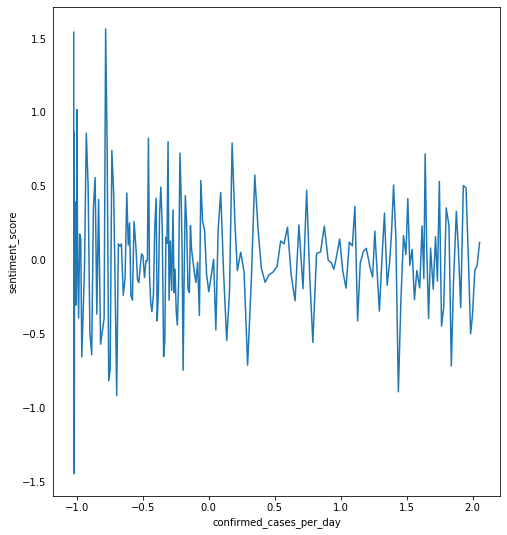

In [194]:
plt.plot(confirmed_death['confirmed_standard'],polarity_pure['sentiment_score_standard'])
plt.xlabel('confirmed_cases_per_day')
plt.ylabel('sentiment_score')

In [197]:
from scipy.stats import spearmanr

In [198]:
corr, pval = spearmanr(confirmed_death['confirmed_standard'],polarity_pure['sentiment_score_standard'])
print('Spearmans correlation: %.3f \n' % corr + 'P-value:%.3f ' % pval)

Spearmans correlation: -0.001 
P-value:0.993 


# How about regional correlation scores?

In [201]:
corr, pval = spearmanr(covid_northeast['confirmed_standard'],polarity_northeast_pure['sentiment_score_standard'])
print('Spearmans correlation: %.3f \n' % corr + 'P-value:%.3f ' % pval)

Spearmans correlation: -0.002 
P-value:0.971 


In [202]:
corr, pval = spearmanr(covid_midwest['confirmed_standard'],polarity_midwest_pure['sentiment_score_standard'])
print('Spearmans correlation: %.3f \n' % corr + 'P-value:%.3f ' % pval)

Spearmans correlation: -0.074 
P-value:0.237 


In [203]:
corr, pval = spearmanr(covid_southeast['confirmed_standard'],polarity_southeast_pure['sentiment_score_standard'])
print('Spearmans correlation: %.3f \n' % corr + 'P-value:%.3f ' % pval)

Spearmans correlation: -0.020 
P-value:0.750 


In [204]:
corr, pval = spearmanr(covid_west['confirmed_standard'],polarity_west_pure['sentiment_score_standard'])
print('Spearmans correlation: %.3f \n' % corr + 'P-value:%.3f ' % pval)

Spearmans correlation: -0.035 
P-value:0.580 


In [205]:
corr, pval = spearmanr(covid_southwest['confirmed_standard'],polarity_southwest_pure['sentiment_score_standard'])
print('Spearmans correlation: %.3f \n' % corr + 'P-value:%.3f ' % pval)

Spearmans correlation: -0.021 
P-value:0.737 
